In [425]:
begin # Import necessary packages
    println("Loading packages...")
    using GLMakie, GeometryBasics, LinearAlgebra, Quaternions, FileIO
    import Quaternions: Quaternion as Quaternion
    println("Packages loaded successfully.")

    cd(@__DIR__) # Changing the current working directory from project root to the parent directory of this file so that pwd() and @__DIR__ match.
    # Import custom code and utility functions
    include("../../src/State_and_Conversions.jl")
    include("../../src/Rendering.jl")
    include("../../src/Transformations.jl")
    include("../../src/WindowManager.jl")
    include("../../src/Recorder.jl")



    # Initialize the custom structs and utilities
    conversions = Conversions()
    renderer = Renderer()
    transformations = Transformations()
    windowmanager = WindowManager()

    println("Custom modules loaded successfully.")

    BlochSphere = GeometryBasics.mesh(Tesselation(Sphere(Point3(0.0, 0.0, 0.0), 1.0), 50))
    nothing
end

Loading packages...
Packages loaded successfully.
Custom modules loaded successfully.


---
# Create Scene

In [426]:
begin 
    scene = Scene(size = (800, 600), camera = cam3d!)
    meshscatter!(scene, Point3(0.0, 0.0, 0.0), markersize=1.0, space=:data, marker=BlochSphere, color=:lightblue, alpha=0.3, transparency=true)


    display(scene)
    nothing

    state00_endpoints = [Point3(0.0, 0.0, 1.0)]
    state00 = Observable(State())
    state00_obs = attach2State(state00_endpoints, state00)

    for i in eachindex(state00_obs)
        meshscatter!(scene, (0, 0, 0), marker=lift(p -> Arrow(p).mesh, state00_obs[i]), color=:black, markersize=1.0)
    end
    coordinate_arrows = drawState!(scene, alpha=0.2, scale=0.5)
    nothing
end

In [427]:
## Add a trail 
begin
    # Adding a little trail at the tip of the [1,1,1] vector in the wingstate 
    # Initialize a circular buffer to store the trail points
    using DataStructures: CircularBuffer
    n = 200 # Buffer size
    buffer = CircularBuffer{Point{3,Float64}}(n)
    for _ in 1:n
        push!(buffer, copy(state00_obs[1][])) # Assuming the 4th vector is the one we want to trail
    end
    buffer = Observable(buffer)

    # Use buffer in plot
    trail = lines!(scene, lift(x -> collect(x), buffer), color=[GLMakie.RGBA(0, 0, 0, 1 - i / n) for i in 0:n-1], linewidth=2)

    # add a lister function to update the buffer whenever the vector changes.
    trail_tracker = on(state00_obs[1]) do new_point
        push!(buffer[], new_point) # Update the buffer with the new point, scaled down
        notify(buffer) # Notify the observable to update the plot
    end
    nothing
end

---

# Quantum Gates as Rotations

In [428]:
function PauliX!(state::Observable{State})
    about_axis = [1.0, 0.0, 0.0] # Pick an Axis, in this case the x axis
    angle = π # Rotate by Pi radians
    toState = State(conversions.axisangle2quat(about_axis, angle) * state[].q) # Calculate the final state upon rotation
    transformations.interpolate_states(state, toState; n=200, time=2.0, rate_function=t -> sin(t * pi / 2)) # Animate from the current state, to the final state
    return nothing
end

function PauliY!(state::Observable{State})
    about_axis = [0.0, 1.0, 0.0]
    angle = π
    toState = State(conversions.axisangle2quat(about_axis, angle) * state[].q)
    transformations.interpolate_states(state, toState; n=200, time=2.0, rate_function=t -> sin(t * pi / 2))
    return nothing
end

function PauliZ!(state::Observable{State})
    about_axis = [0.0, 0.0, 1.0]
    angle = π
    toState = State(conversions.axisangle2quat(about_axis, angle) * state[].q)
    transformations.interpolate_states(state, toState; n=200, time=2.0, rate_function=t -> sin(t * pi / 2))
    return nothing
end

function Rx!(state::Observable{State}, theta::Float64)
    about_axis = [1.0, 0.0, 0.0]
    angle = theta
    toState = State(conversions.axisangle2quat(about_axis, angle) * state[].q)
    transformations.interpolate_states(state, toState; n=200, time=2.0, rate_function=t -> sin(t * pi / 2))
    return nothing
end

function Ry!(state::Observable{State}, theta::Float64)
    about_axis = [0.0, 1.0, 0.0]
    angle = theta
    toState = State(conversions.axisangle2quat(about_axis, angle) * state[].q)
    transformations.interpolate_states(state, toState; n=200, time=2.0, rate_function=t -> sin(t * pi / 2))
    return nothing
end

function Rz!(state::Observable{State}, theta::Float64)
    about_axis = [0.0, 0.0, 1.0]
    angle = theta
    toState = State(conversions.axisangle2quat(about_axis, angle) * state[].q)
    transformations.interpolate_states(state, toState; n=200, time=2.0, rate_function=t -> sin(t * pi / 2))
    return nothing
end

function Reset!(state::Observable{State})
    transformations.interpolate_states(state, State(); n=200, time=2.0, rate_function=t -> sin(t * pi / 2))
    return nothing
end

function Not!(state::Observable{State})
    PauliX!(state)
    return nothing
end

function Hadamard!(state::Observable{State})
    about_axis = normalize([1.0, 0.0, 1.0])
    angle = π
    toState = State(conversions.axisangle2quat(about_axis, angle) * state[].q)
    transformations.interpolate_states(state, toState; n=200, time=2.0, rate_function=t -> sin(t * pi / 2))
    return nothing
end

function draw_axis(scene, about_axis)
    try
        delete!(scene, ax_mesh)
    catch
    end
    global ax_mesh = meshscatter!(scene, Point3(0.0, 0.0, 0.0), markersize=1.0, space=:data, marker=Arrow(Point3(about_axis).*0.75).mesh, alpha=0.5, transparency=true, color=:cyan)
    return ax_mesh
end


draw_axis (generic function with 1 method)

In [429]:
Not!(state00)

---

In [430]:
about_axis = normalize([1.0, 1.0, 1.0])
angle = pi/1.0

draw_axis(scene, about_axis)

transformations.interpolate_states(state00, State(conversions.axisangle2quat(about_axis, angle) * state00[].q); n=200, time=2.0, rate_function=t -> sin(t * pi / 2))

In [431]:
delete!(scene, ax_mesh)

In [432]:
Reset!(state00)

## Using Predefined Rotations

In [435]:
PauliZ!(state00)

In [436]:
Ry!(state00, 45*pi/180)

## Measurement

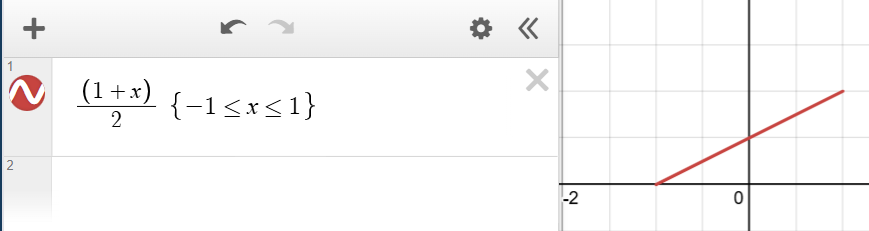

$$z \in [-1, 1]$$

To map $z$ to the probabilities $[0, 1]$, you need to apply a linear map. So we shift everything by $1$ and scale it down by $2$.

In [362]:
function calculateCollapseProbabilities(state::AbstractVector)
    # Calculate the probabilities of measuring |0⟩ and |1⟩
    # For a Bloch vector [x, y, z], probability of |0⟩ is (1 + z)/2
    prob_0 = (1 + state[3]) / 2
    prob_1 = (1 - state[3]) / 2

    println("Probability of measuring |0⟩: ", prob_0*100, "%")
    println("Probability of measuring |1⟩: ", prob_1*100, "%")
    return prob_0, prob_1
end

calculateCollapseProbabilities (generic function with 4 methods)

In [386]:
calculateCollapseProbabilities(state00_obs[1][])

Probability of measuring |0⟩: 100.0%
Probability of measuring |1⟩: 0.0%


(1.0, 0.0)

In [439]:
Reset!(state00)

In [342]:
PauliX!(state00)

In [441]:
Rx!(state00, pi/2)

In [424]:
calculateCollapseProbabilities(state00_obs[1][])

Probability of measuring |0⟩: 24.999999999999993%
Probability of measuring |1⟩: 75.0%


(0.24999999999999994, 0.75)

### Assuming the Hadamard Gate is also just applying a rotation around an axis, what must be the axis and what must be the angle of rotation?

In [457]:
Reset!(state00)
# Not!(state00)

In [447]:
# Axis and Angle for a Hadamard Gate
# Applying the transformation animation
begin
    about_axis = normalize([1.0, 0.0, 1.0]) ## -> The axis must be in the x-z plane, and at a 45 degree angle to both the x and z axes.
    angle = pi

    draw_axis(scene, about_axis)

    transformations.interpolate_states(state00, State(conversions.axisangle2quat(about_axis, angle) * state00[].q); n=200, time=2.0, rate_function=t -> sin(t * pi / 2))
end

In [449]:
delete!(scene, ax_mesh)

---

## Let's Do Stuff!

Starting from $\ket{0}$, apply any sequence of Quantum Gates you want to get the Qubit to `normalize([1,1,0.0]).+[0,0,0.5]`

In [455]:
q1_mesh = meshscatter!(scene, Point3(0.0, 0.0, 0.0), markersize=1.0, space=:data, marker=Arrow(normalize(normalize(Point3(1.0, 1.0, 0.0)).+(0,0,0.5))).mesh, color=:yellow)

MeshScatter{Tuple{Vector{Point{3, Float64}}}}

In [458]:
Hadamard!(state00)

In [ ]:
Ry!(state00, -pi/6)

In [462]:
Rz!(state00, pi/4)

In [464]:
calculateCollapseProbabilities(state00_obs[1][])

Probability of measuring |0⟩: 75.0%
Probability of measuring |1⟩: 25.0%


(0.75, 0.25)

In [456]:
Not!(state00)

In [402]:
Hadamard!(state00)

In [411]:
Ry!(state00, pi/4)

In [463]:
delete!(scene, q1_mesh)

In [410]:
Reset!(state00)

What would be the probability for measuring the qubit as $\ket{0}$ and $\ket{1}$ at this state?

If the probability of measuring the qubit in $\ket{0}$ is $25\%$ and in $\ket{1}$ is $75\%$.